# W207 Final Project: Forest Cover Type Prediction
**Ehsan Yousefzadeh and Andrew Walters**

## About the Dataset

The study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. Each observation is a 30m x 30m patch. Our goal is to predict an integer classification for the forest cover type. The seven types are:

1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

The training set contains 15,120 labeled observations, which we divided 80/20 into *train_data_1* and *train_data_2*. The second set was used for internal validation. The unlabeled test set contains 565,892 observations was used in the Kaggle submission.

### Data Fields

- Elevation - Elevation in meters
- Aspect - Aspect in degrees azimuth
- Slope - Slope in degrees
- Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway
- Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
- Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
- Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
- Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points
- Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
- Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
- Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

## Project Setup and Data Exploration

In [142]:
#data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import graphviz 
import pydot

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO
from sklearn import tree


### Data Loading

In [143]:
#Read the data from the two seperate CSV files 
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

Here we see that the training data has 15120 labeled samples.

In [144]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
Id                                    15120 non-null int64
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_T

And the test data has 565891 unlabled samples.

In [145]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565892 entries, 0 to 565891
Data columns (total 55 columns):
Id                                    565892 non-null int64
Elevation                             565892 non-null int64
Aspect                                565892 non-null int64
Slope                                 565892 non-null int64
Horizontal_Distance_To_Hydrology      565892 non-null int64
Vertical_Distance_To_Hydrology        565892 non-null int64
Horizontal_Distance_To_Roadways       565892 non-null int64
Hillshade_9am                         565892 non-null int64
Hillshade_Noon                        565892 non-null int64
Hillshade_3pm                         565892 non-null int64
Horizontal_Distance_To_Fire_Points    565892 non-null int64
Wilderness_Area1                      565892 non-null int64
Wilderness_Area2                      565892 non-null int64
Wilderness_Area3                      565892 non-null int64
Wilderness_Area4                      565892 non-

In [146]:
#Create function to test shape of data for consistency
def shape():
    print("Train 1 Shape: ", train_data_1_p.shape)
    print("Train 2 Shape: ", train_data_2_p.shape)
    print("Test Shape: ", test_data.shape)

In [147]:
#Shuffle the training data
train_data = shuffle(train_data)

#Set training labels to cover type and drop the feature from the training data set
train_labels = train_data['Cover_Type']
train_data = train_data.drop(['Cover_Type'], axis = 1)

#Create ID labels for submission, drop ID for train and test data 
submission = pd.DataFrame({"Id": test_data["Id"]})
train_data = train_data.drop(['Id'], axis = 1)
test_data = test_data.drop(['Id'], axis = 1)

#Split raw training data and labels into two sets: one for model building (training 1) and another for testing (training 2)
train_data_1 = train_data[0:12000]
train_data_2 = train_data[12000::]
train_labels_1 = train_labels[0:12000]
train_labels_2 = train_labels[12000::]

### Descriptive Statistics
- There is a high variability in mean and standard deviation within the continuous variables. This indicates that we should normalize the inputs for some algorithms.
- The binary variables are very sparse.

**Continuous Variables**

In [148]:
train_data.iloc[:,:9].describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997
std,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000
50%,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000
75%,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000
max,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000


**Binary Variables**

In [149]:
train_data.iloc[:,10:].describe()

,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,0.237897,0.033003,0.419907,0.309193,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,...,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357
std,0.425810,0.178649,0.493560,0.462176,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,...,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Histograms

**Continuous Variables**

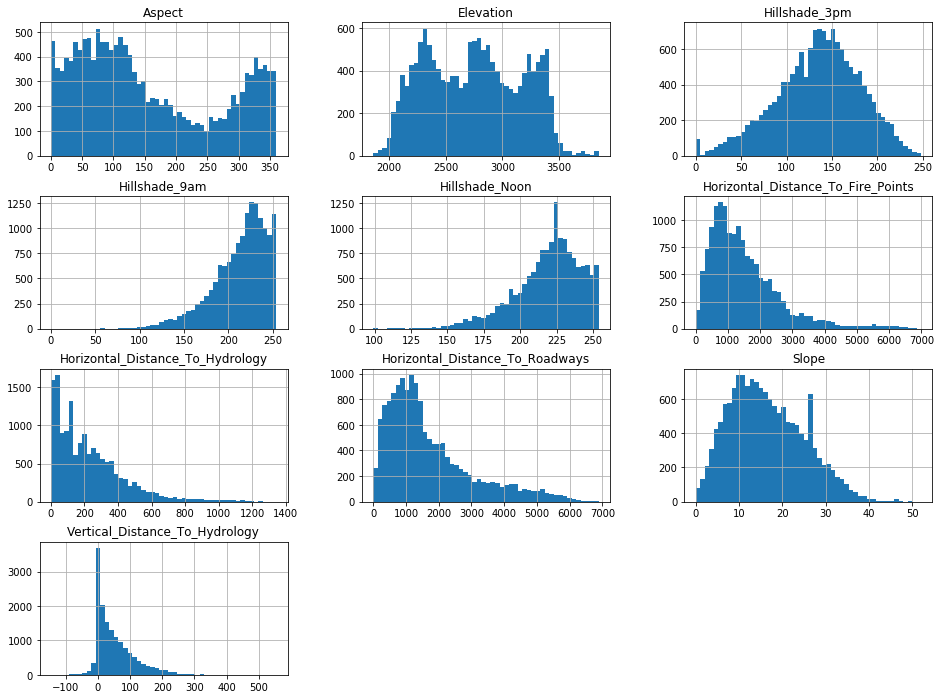

In [150]:
#Histogram chart of key variables 
train_data.iloc[:,:10].hist(figsize=(16,12),bins=50)
plt.show()

- We notice that the aspect variable is bimodal. This makes sense because the data is measured in 360 degrees. Essentially, the value 10 is relatively equal to 350 as they are both 10 degrees away from facing north. 
- The elevation variable does not appear to be normally distributed as the data appears to be clustered. 
- Hillshade_3pm appears to be normally distributed however there appears to be a handful of 0s in the variable. Hillshade 9am and Hillshade_Noon appear to have negative skews. 
- Horizontal distance to hydrology and horizontal distance to roadway both appear to be positively skewed.
- Vertical distance to hydrology appears to be positively skewed with some values being negative which is notable. 
- The slope variable appears to be normally distributed however there are outlier values in the high 20s. 

**Binary Variables**

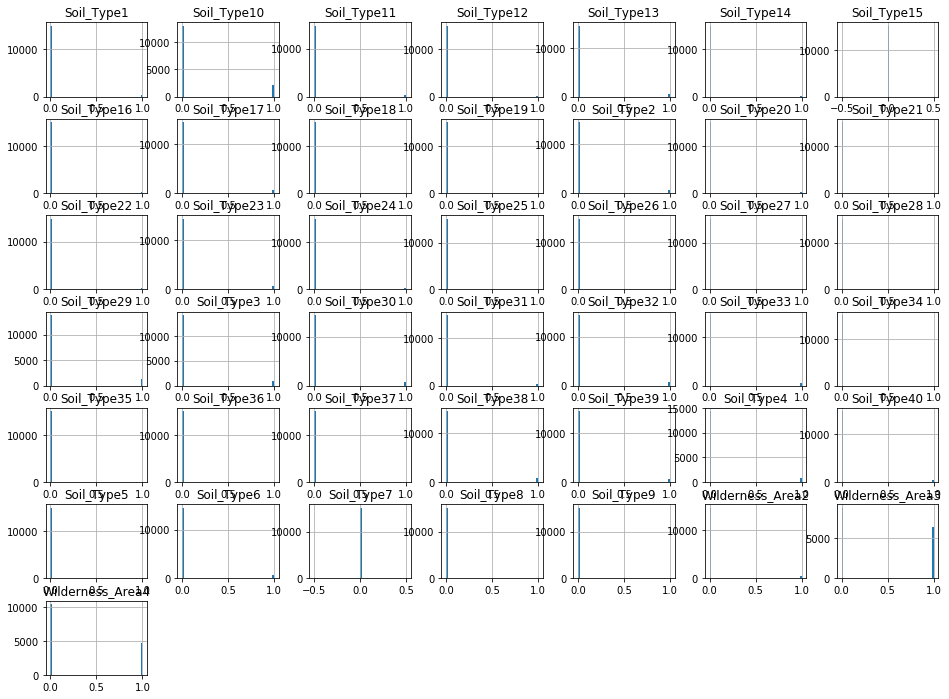

In [151]:
#Histogram chart of soil types 
train_data.iloc[:,11:].hist(figsize=(16,12),bins=50)
plt.show()

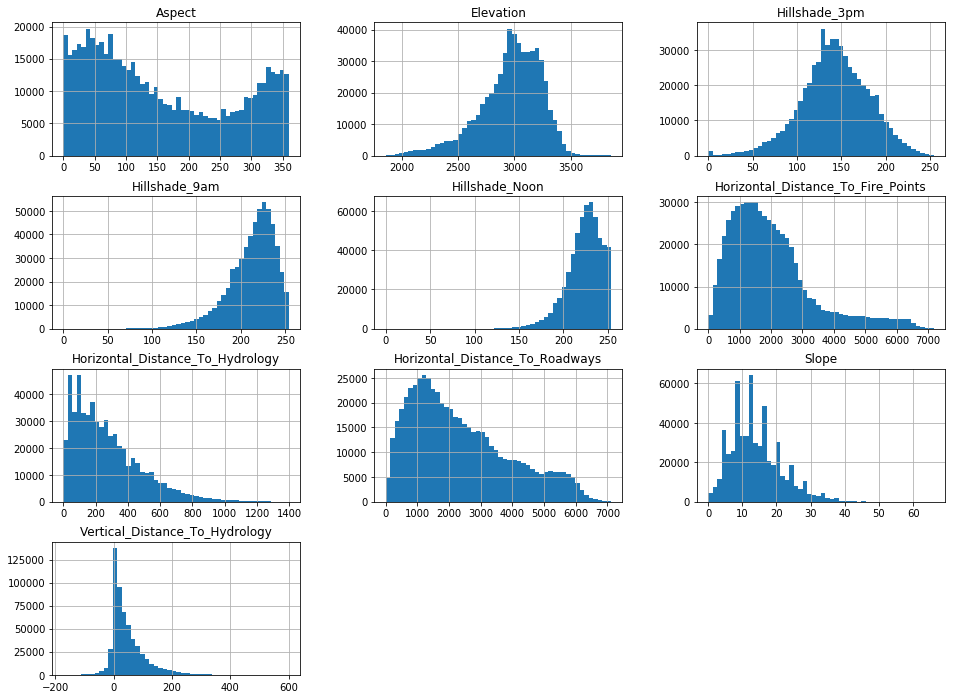

In [152]:
#Histogram charts of test data variables 
test_data.iloc[:,:10].hist(figsize=(16,12),bins=50)
plt.show()

The test data also shows the same patterns as the training data. However, the slope variable appears to be even more clustered around certain values. The data collection for the slope appears to have an issue. 

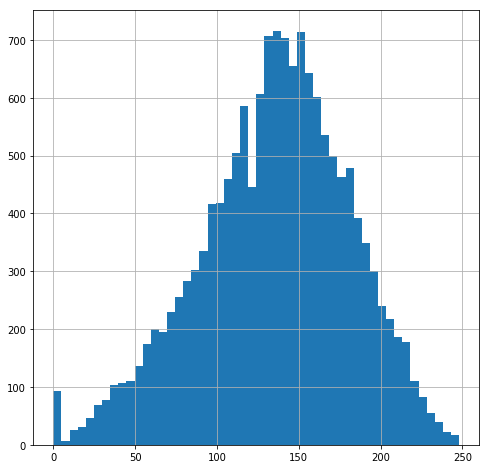

In [153]:
#Histogram of Hillshade_3pm training data 
train_data.Hillshade_3pm.hist(figsize=(8,8),bins=50)
plt.show()

A closer look at the training data Hillshade_3pm variable that displays the collection of 0 values more clearly. 

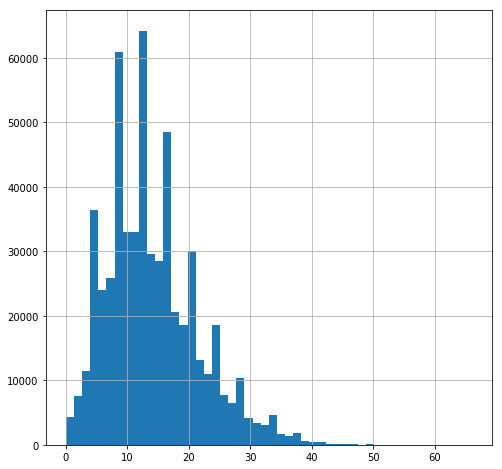

In [154]:
#Histogram of Slope variable for test data 
test_data.Slope.hist(figsize=(8,8),bins=50)
plt.show()

A closer look at the test data slope variable that shows the values being clustered. 

#### Histograms Separated by Label

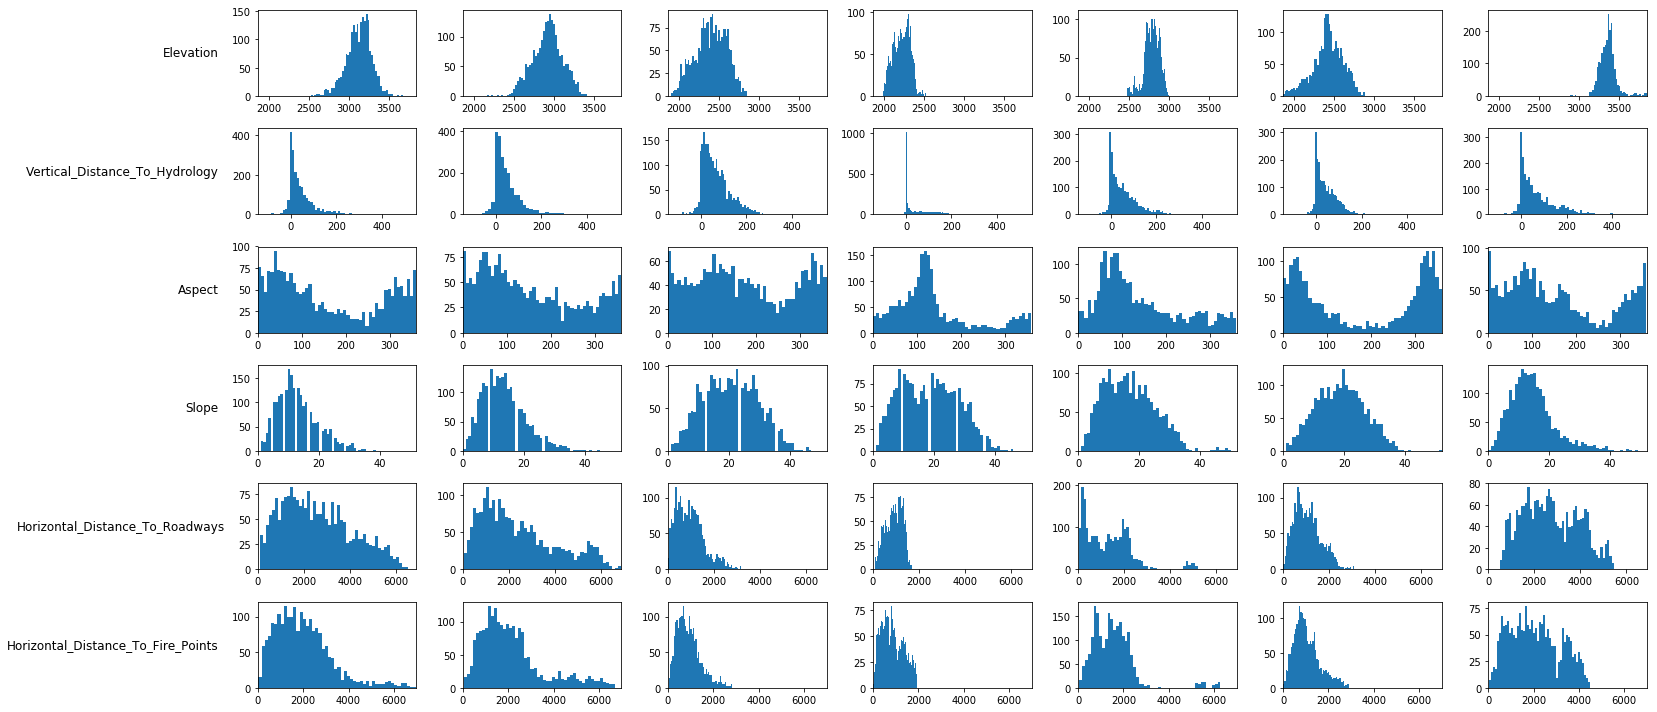

In [155]:
# setup plot
interesting_cols = ['Elevation',
                    'Vertical_Distance_To_Hydrology',
                    'Aspect',
                    'Slope',
                    'Horizontal_Distance_To_Roadways',
                    'Horizontal_Distance_To_Fire_Points']
labels = list(train_labels.unique())
labels.sort()
f,a = plt.subplots(len(interesting_cols), len(labels))
f.set_figwidth(20)
f.set_figheight(10)
xaxis_mins = train_data.min()
xaxis_maxs = train_data.max()
pad=5

# loop over each column and each label
for ind,col in enumerate(interesting_cols):
    for label in labels:
        ax = a[ind, int(label)-1]
        ax.hist(list(train_data[col][train_labels==label]),bins=50)
        ax.set_xlim(xaxis_mins[col], xaxis_maxs[col])

# label each row
for ax, label in zip(a[:,0], list(interesting_cols)):
    ax.annotate(label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
        xycoords=ax.yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center')

f.tight_layout()
plt.show()

### Correlation Map
This shows the linear correlation between each pair of continuous variables in our dataset, where a brighter colors indicate highly linearly correlated variables.

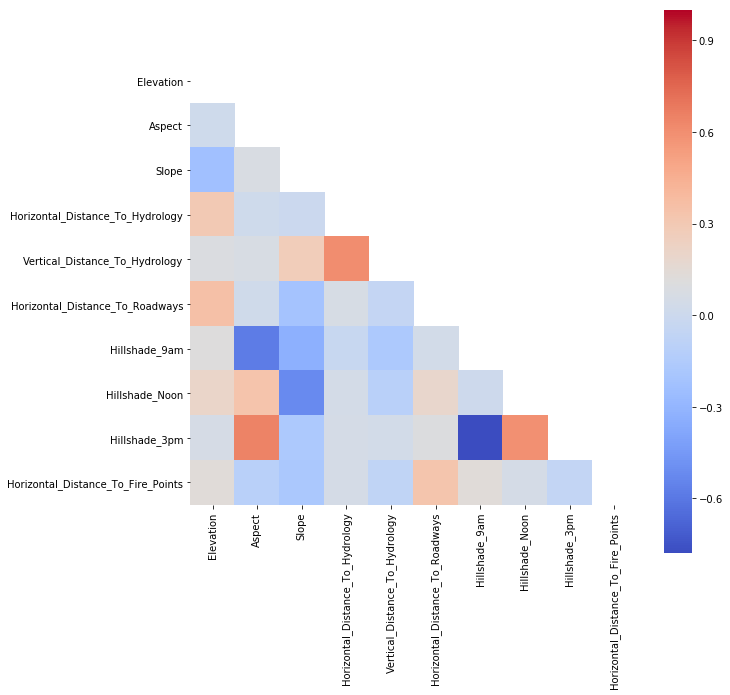

In [156]:
corr_test = test_data.iloc[:,:10].corr()
mask = np.zeros_like(corr_test, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_test, cmap = 'coolwarm', mask = mask, 
            square = True)

We can see that all 3 hillshade types have correlations with one and other as we would expect. We can also see that slope is closely correlated with the hillshade variables as well. We notice that the elevation variable is correlated with slope and the horizontal distance to hydrology and roadways. We also notice that horizontal distance to hydrology is correlated with vertical distance to hydrology. 

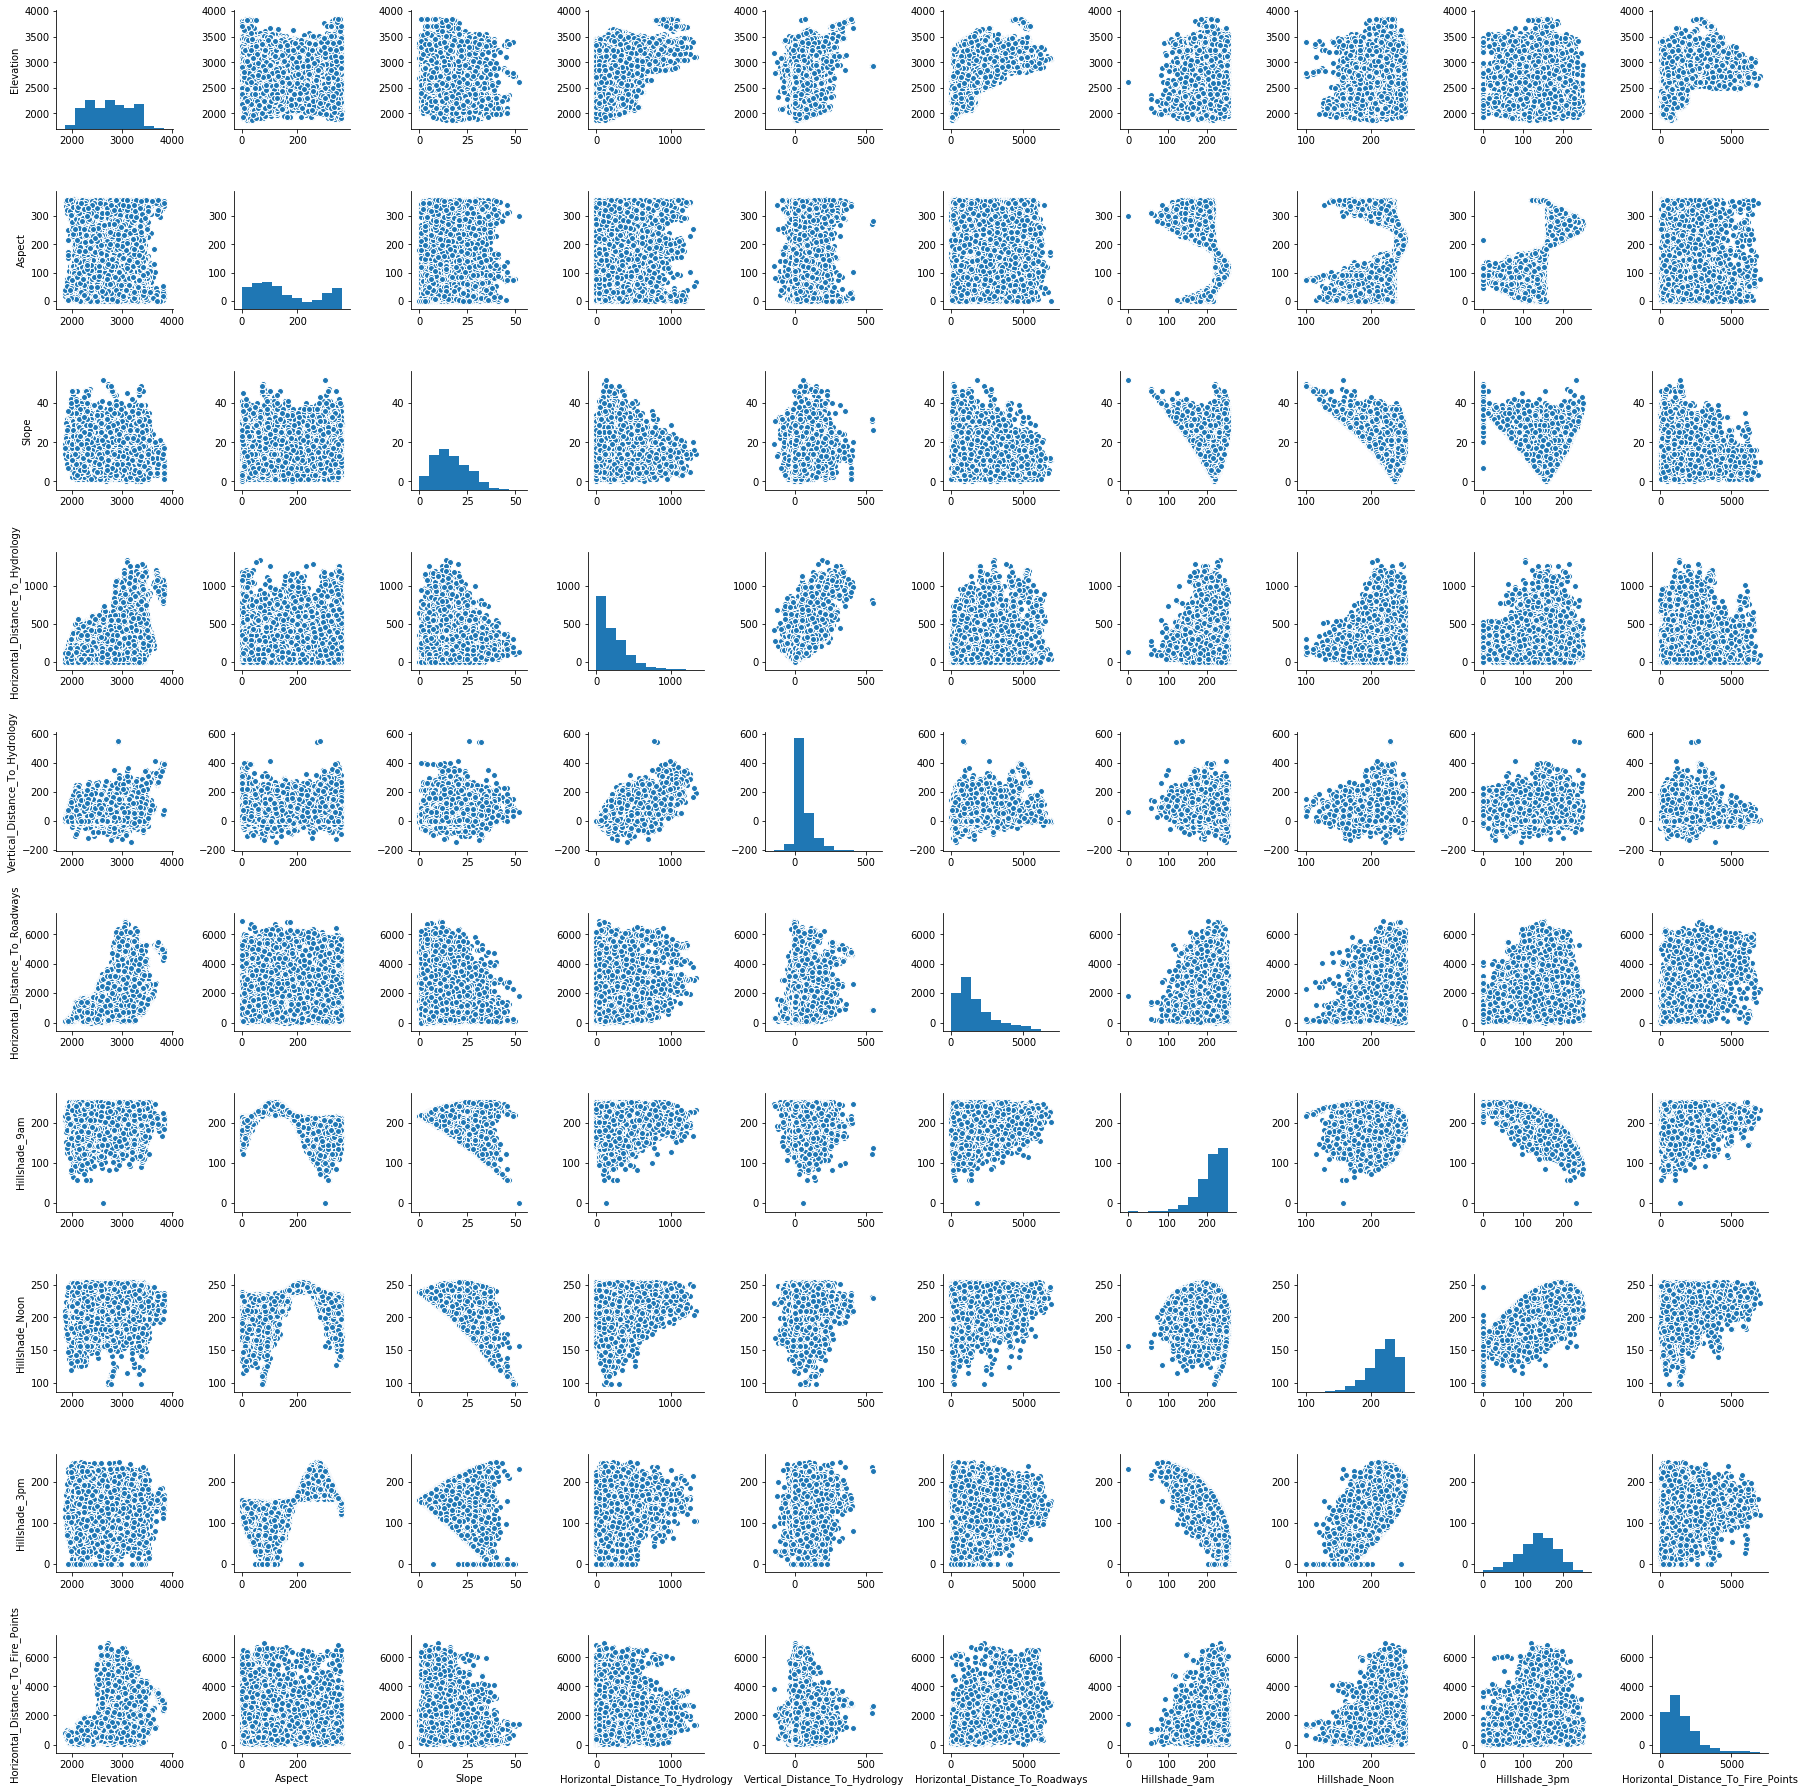

In [157]:
sns.pairplot(train_data.iloc[:,:10]);

## Feature Engineering

#### First start by addressing the zero values of the hillshade 3pm feature and replace the zero values with the median values. 


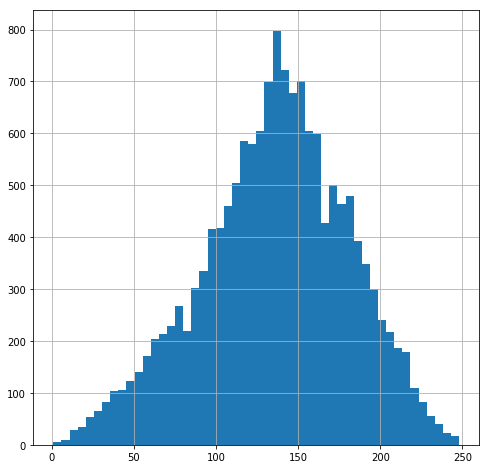

In [158]:
#Determine median value of HillShade_3pm 
median_hillshade3pm = train_data['Hillshade_3pm'].median()
median_hillshade3pm_test = test_data['Hillshade_3pm'].median()

#Replace zero values with the median value
train_data['Hillshade_3pm']=train_data.Hillshade_3pm.mask(train_data.Hillshade_3pm == 0,median_hillshade3pm)
test_data['Hillshade_3pm']=test_data.Hillshade_3pm.mask(test_data.Hillshade_3pm == 0,median_hillshade3pm_test)

#Plot histogram of adjusted feature 
train_data.Hillshade_3pm.hist(figsize=(8,8),bins=50)
plt.show()

#### Lets create some new features that exploits the relationship between Elevation and the distances to hydrology. 

In [159]:
#New features equal to differences between elevation and distance to hydrology 
train_data['EV_VH'] = train_data.Elevation-train_data.Vertical_Distance_To_Hydrology
test_data['EV_VH'] = test_data.Elevation-test_data.Vertical_Distance_To_Hydrology

train_data['EV_HH'] = train_data.Elevation-train_data.Horizontal_Distance_To_Hydrology
test_data['EV_HH'] = test_data.Elevation-test_data.Horizontal_Distance_To_Hydrology

#### Create a new feature that is the euclidean distance to hydrology

In [160]:
#Create a feature that is the euclidean distance of the horizontal and vertical distance to hydrology
train_data['Hydrology_euclid'] = (train_data['Horizontal_Distance_To_Hydrology']**2+train_data['Vertical_Distance_To_Hydrology']**2)**0.5
test_data['Hydrology_euclid'] = (test_data['Horizontal_Distance_To_Hydrology']**2+test_data['Vertical_Distance_To_Hydrology']**2)**0.5

#### Create a new feature that gives a boolean value whether or not the vertical distance to hydrology is positive or negative 

In [161]:
#Create a feature that notes whether or not the vertical distance to hydrology is positive or negative (ie above or below)
train_data['Water_test'] = train_data.Vertical_Distance_To_Hydrology < 0
test_data['Water_test'] = test_data.Vertical_Distance_To_Hydrology < 0

#### Create a new feature that adjusts the aspect ratio from 360 degrees to 180 degrees (0 for South and 180 for North)

In [162]:
#Create a feature that adjusts the 360 degree of the Aspect to 180 degrees for North to South 
#since we only care about the number of degrees from these poles 

def adjustment(x):
    if x+180>360:
        return x-180
    else:
        return x+180

train_data['Aspect_Adjustment'] = train_data.Aspect.map(adjustment)
test_data['Aspect_Adjustment'] = test_data.Aspect.map(adjustment)
train_data = train_data.drop(['Aspect'], axis = 1)
test_data = test_data.drop(['Aspect'], axis = 1)

#### Lets drop the old features since we created new ones and we don't want to create much duplicity. 

In [163]:
#Drop features that were added so there is no redundancy 
#Lets also remove the Slope feature since the data looks clustered. Possible sampling error in the data. 
train_data = train_data.drop(
    ['Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology'], axis = 1)
test_data = test_data.drop(
    ['Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology'], axis = 1)

In [164]:
train_data = train_data.drop(
    ['Slope'], axis = 1)
test_data = test_data.drop(
    ['Slope'], axis = 1)

In [165]:
train_data = train_data.drop(
    ['Elevation'], axis = 1)
test_data = test_data.drop(
    ['Elevation'], axis = 1)

In [166]:
train_data = train_data.drop(['Hillshade_3pm', 'Hillshade_9am'], axis = 1)
test_data = test_data.drop(['Hillshade_3pm', 'Hillshade_9am'], axis = 1)

In [167]:
#Split the pre-processed training data into two sets so we can test
train_data_1_p = train_data[0:12000]
train_data_2_p = train_data[12000::]

In [168]:
shape()

Train 1 Shape:  (12000, 52)
Train 2 Shape:  (3120, 52)
Test Shape:  (565892, 52)


# Run a Tour of Classifiers with the Unprocessed Data

In [169]:
#Run a tour of classifiers with the base training data to see which classifiers perform well 

#logistic regression
logistic = LogisticRegression()
logistic.fit(train_data_1, train_labels_1)
forest_log = logistic.score(train_data_2, train_labels_2)

#perceptron
perceptron = Perceptron()
perceptron.fit(train_data_1, train_labels_1)
forest_perceptron = perceptron.score(train_data_2, train_labels_2)

#decision tree
decision_tree = DecisionTreeClassifier(max_depth = 15)
decision_tree.fit(train_data_1, train_labels_1)
forest_decision_tree = decision_tree.score(train_data_2, train_labels_2)

#extra tree
extra_tree = ExtraTreesClassifier(n_estimators=400, criterion='gini', max_depth=None, 
    min_samples_split=2, min_samples_leaf=1, max_features='auto', 
    bootstrap=False, oob_score=False, n_jobs=-1, random_state=None, verbose=0)
extra_tree.fit(train_data_1, train_labels_1)
forest_extra_tree = extra_tree.score(train_data_2, train_labels_2)

#linear svc
linear_svc = LinearSVC()
linear_svc.fit(train_data_1, train_labels_1)
forest_linear_svc = linear_svc.score(train_data_2, train_labels_2)

#knn
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(train_data_1, train_labels_1)
forest_knn = knn.score(train_data_2, train_labels_2)

#gaussian nb
gaussian = GaussianNB()
gaussian.fit(train_data_1, train_labels_1)
forest_gaussian = gaussian.score(train_data_2, train_labels_2)

#gradient descent
sgd = SGDClassifier()
sgd.fit(train_data_1, train_labels_1)
forest_sgd = sgd.score(train_data_2, train_labels_2)

#random forest 
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train_data_1, train_labels_1)
forest_random_forest = random_forest.score(train_data_2, train_labels_2)

#ada boost with decision tree
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=15), n_estimators=500, learning_rate=0.5)
abc.fit(train_data_1, train_labels_1)
forest_adaboost = abc.score(train_data_2, train_labels_2)

#adaboost with random forest 
abc2 = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=100), n_estimators=500, learning_rate=0.5)
abc2.fit(train_data_1, train_labels_1)
forest_adaboost2 = abc2.score(train_data_2, train_labels_2)

#Assemble results in a table 
classifiers = pd.DataFrame({
    'Classifier': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Gaussian NB','Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'AdaBoost Base Decision Tree','AdaBoost Base Random Forest', 'ExtraTree'],
    'Score': [forest_knn, forest_log, 
              forest_random_forest, forest_gaussian, forest_perceptron, 
              forest_sgd, forest_linear_svc, forest_decision_tree, forest_adaboost,forest_adaboost2, forest_extra_tree]})
classifiers.sort_values(by='Score', ascending=False)



/Users/ehsanyousefzadeh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/ehsanyousefzadeh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


,Classifier,Score
8,AdaBoost Base Decision Tree,0.875641
10,ExtraTree,0.863782
9,AdaBoost Base Random Forest,0.858654
2,Random Forest,0.851603
0,KNN,0.816987
7,Decision Tree,0.781731
1,Logistic Regression,0.671154
3,Gaussian NB,0.592308
4,Perceptron,0.246474
6,Linear SVC,0.227564


We can see from the table that the best performing classifiers are the ensemble classifiers as well as KNN. One noteworthy comparison is the performance improvement of extra trees over random forrests. These two ensamble methonds are esentially the same in that they take samples of the training data to build an array of descion trees, each of which casts a vote. The difference between the methods is the additional randomness of extra trees, where a random jitter is added to the information gain criterea yeilding a non-deterministic desicion tree.

Since there is a clear separation between the ensemble classifiers (and knn) and the remaining classifiers, we're going to proceed with optimizing our features and parameters for those clasifiers.

# Classifiers With Pre-Processed Data

## Ensemble Classifier Comparison with Pre-Processed Data

In [170]:
#Selecting the best-performing classifiers and running them with the pre-processed data

decision_tree = DecisionTreeClassifier(max_depth = 15)
decision_tree.fit(train_data_1_p, train_labels_1)
forest_decision_tree_p = decision_tree.score(train_data_2_p, train_labels_2)

extra_tree = ExtraTreesClassifier(n_estimators=400, criterion='gini', max_depth=None, 
    min_samples_split=2, min_samples_leaf=1, max_features='auto', 
    bootstrap=False, oob_score=False, n_jobs=-1, random_state=None, verbose=0)
extra_tree.fit(train_data_1_p, train_labels_1)
forest_extra_tree_p = extra_tree.score(train_data_2_p, train_labels_2)

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train_data_1_p, train_labels_1)
forest_random_forest_p = random_forest.score(train_data_2_p, train_labels_2)

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=15), n_estimators=500, learning_rate=0.5)
abc.fit(train_data_1_p, train_labels_1)
forest_adaboost_p = abc.score(train_data_2_p, train_labels_2)

abc2 = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=100), n_estimators=500, learning_rate=0.5)
abc2.fit(train_data_1_p, train_labels_1)
forest_adaboost2_p = abc2.score(train_data_2_p, train_labels_2)

classifiers = pd.DataFrame({
    'Classifier': ['Random Forest','Decision Tree', 'AdaBoost Base Decision Tree','AdaBoost Base Random Forest', 'ExtraTree'],
    'Score': [forest_random_forest_p,forest_decision_tree_p, forest_adaboost_p,  forest_adaboost2_p,forest_extra_tree_p]})
classifiers.sort_values(by='Score', ascending=False)


,Classifier,Score
4,ExtraTree,0.885577
2,AdaBoost Base Decision Tree,0.884295
3,AdaBoost Base Random Forest,0.877244
0,Random Forest,0.875000
1,Decision Tree,0.802244


We notice significant improvement of classifiers after running the processed data with our new features. 

#### Check the importance of features for our classifier

In [171]:
pd.DataFrame(extra_tree.feature_importances_,index=train_data.columns).sort_values([0], ascending=False) [:20]

,0
EV_VH,0.167152
EV_HH,0.101255
Horizontal_Distance_To_Roadways,0.093327
Horizontal_Distance_To_Fire_Points,0.080258
Hydrology_euclid,0.078093
Aspect_Adjustment,0.070051
Hillshade_Noon,0.058161
Wilderness_Area4,0.054945
Soil_Type10,0.032422
Soil_Type38,0.024852


We can see that our new features have made it to the top of the list on the table of features by importance.

In [172]:
#Take a look at the classification report 
extra_predicted_labels = extra_tree.predict(train_data_2_p)
print("Extra Tree Classification Report: \n", classification_report(train_labels_2, extra_predicted_labels))
print("Confusion Matrix: \n",confusion_matrix(train_labels_2, extra_predicted_labels))

Extra Tree Classification Report: 
              precision    recall  f1-score   support

          1       0.79      0.80      0.79       410
          2       0.85      0.73      0.78       470
          3       0.89      0.85      0.87       457
          4       0.94      0.98      0.96       442
          5       0.91      0.96      0.93       436
          6       0.87      0.91      0.89       449
          7       0.94      0.97      0.96       456

avg / total       0.88      0.89      0.88      3120

Confusion Matrix: 
 [[328  51   0   0   7   0  24]
 [ 76 342   7   0  28  14   3]
 [  0   5 389  18   5  40   0]
 [  0   0   9 432   0   1   0]
 [  1   3   5   0 419   8   0]
 [  0   1  28   8   2 410   0]
 [ 11   2   0   0   0   0 443]]


We notice that the classifier tends to have a hard time distinguishing between cover types 1 and 2. 

## K-Nearest Neighbors Experiment With Normalized and Scaled Data

This is nearest neighbors with default parameters (except p=1 for manhattan distance) and engineered features

In [173]:
knn = KNeighborsClassifier(n_neighbors=1,p=1)
knn.fit(train_data_1_p,train_labels_1)
print("KNN Accuracy with non-normalized and non-scaled data", knn.score(train_data_2_p,train_labels_2))

KNN Accuracy with non-normalized and non-scaled data 0.842948717949


In [174]:
# normalize the data, 
scaled_train_data_1 = pd.DataFrame(preprocessing.scale(train_data_1_p),columns=train_data_1_p.columns)
scaled_train_data_2 = pd.DataFrame(preprocessing.scale(train_data_2_p),columns=train_data_2_p.columns)

# return the binary features to the scaled dataframe
scaled_train_data_1.loc[:,'Wilderness_Area1':'Soil_Type40'] = train_data_1.loc[:,'Wilderness_Area1':'Soil_Type40'].values
scaled_train_data_2.loc[:,'Wilderness_Area1':'Soil_Type40'] = train_data_2.loc[:,'Wilderness_Area1':'Soil_Type40'].values

# add weights to some columns
weight_cols = ['EV_VH',
               'EV_HH',
               'Horizontal_Distance_To_Roadways',
               'Horizontal_Distance_To_Fire_Points']
weights = [4,
           1,
           5,
           5]
for w,c in zip(weights,weight_cols):
    scaled_train_data_1.loc[:,c] = scaled_train_data_1.loc[:,c].values * w
    scaled_train_data_2.loc[:,c] = scaled_train_data_2.loc[:,c].values * w

Next we nomalized the data, which subtracts the mean and divides by the variance. We kept the binary data as-is, and tuned our classifier by adjusting the weights to a few columns. Normalizing by itself showed little improvement, but scaling some columns yeilded 1% or greater gains in accuracy against the development testing set. Scaling a column means that the cost of distance for that feature is greater, giving it greater weight in classification.

In [175]:
knn = KNeighborsClassifier(n_neighbors=1,p=1) #these are manually optimized
knn.fit(scaled_train_data_1,train_labels_1)
knn_predicted_labels = knn.predict(scaled_train_data_2)
knn_score = knn.score(scaled_train_data_2,train_labels_2)
print("KNN Accuracy with normalized and scaled data: ", knn.score(scaled_train_data_2,train_labels_2))
#use the classification report 
print("KNN Classification Report: \n", classification_report(train_labels_2, knn_predicted_labels))
print("Confusion Matrix: \n",confusion_matrix(train_labels_2, knn_predicted_labels))

KNN Accuracy with normalized and scaled data:  0.878846153846
KNN Classification Report: 
              precision    recall  f1-score   support

          1       0.79      0.78      0.79       410
          2       0.81      0.71      0.76       470
          3       0.90      0.86      0.88       457
          4       0.93      0.98      0.95       442
          5       0.89      0.96      0.92       436
          6       0.87      0.90      0.88       449
          7       0.95      0.98      0.96       456

avg / total       0.88      0.88      0.88      3120

Confusion Matrix: 
 [[320  56   0   0  12   0  22]
 [ 75 336   8   0  33  16   2]
 [  0   8 391  19   4  35   0]
 [  0   0   7 431   0   4   0]
 [  1   7   4   0 417   7   0]
 [  1   4  25  13   4 402   0]
 [  7   4   0   0   0   0 445]]


The confusion matrix for KNN also reveals difficulty in classifying between cover types 1 and 2. 

# Parameter Tuning

#### Tune the Extra Trees Classifier

In [176]:
#Define parameters to search through
param_grid = {"max_depth": [10, None],
             "max_features": [1, 3, 10, 'auto'],
             "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}


#Setup gridsearchCV
extra_tree = ExtraTreesClassifier(n_estimators = 50)
extra_tree.fit(train_data_1_p, train_labels_1)
forest_extra_tree_p = extra_tree.score(train_data_2_p, train_labels_2)


grid_extra_tree = GridSearchCV(estimator = extra_tree, param_grid = param_grid )
grid_extra_tree.fit(train_data_1_p, train_labels_1)
# print(grid_extra_tree.best_estimator_)
print(grid_extra_tree.best_estimator_)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=10, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [186]:
#Run classifier again with GridSearchCV results
extra_tree = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features=10, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
extra_tree.fit(train_data_1_p, train_labels_1)
forest_extra_tree = extra_tree.score(train_data_2_p, train_labels_2)
print("Extra Tree Accuracy untuned: ", forest_extra_tree_p)
print("Extra Tree Accuracy with tuned parameters: ", forest_extra_tree)

Extra Tree Accuracy untuned:  0.883974358974
Extra Tree Accuracy with tuned parameters:  0.884294871795


We notice slight improvement after tuning the parameters using GridSearchCV.

#### Tune KNN Classifier

In [178]:
#Define parameters to search through
param_grid = {"n_neighbors": [1, 3, 5, 7, 9], "p": [1, 2]}


#Setup gridsearchCV
knn_tuned = KNeighborsClassifier()
knn_tuned.fit(scaled_train_data_1,train_labels_1)

grid_knn = GridSearchCV(estimator = knn_tuned, param_grid = param_grid )
grid_knn.fit(scaled_train_data_1,train_labels_1)
print(grid_knn.best_estimator_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=1,
           weights='uniform')


In [179]:
#Run classifier again with GridSearchCV results
knn_tuned2 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=1,
           weights='uniform')
knn_tuned2.fit(scaled_train_data_1,train_labels_1)
forest_knn_tuned_2 = knn_tuned2.score(scaled_train_data_2, train_labels_2)
print("KNN Accuracy untuned: ", knn_score)
print("KNN Accuracy with tuned parameters: ", forest_knn_tuned_2)

KNN Accuracy untuned:  0.878846153846
KNN Accuracy with tuned parameters:  0.878846153846


Same accuracy as we had previously done because of manual tuning and limited paramters available to tune. 

## Kaggle Submission
The extra tree classifier was in the top 20% percent of Kaggle submisisons.

In [180]:
# # # Kaggle Submission

# # extra_tree = ExtraTreesClassifier(n_estimators = 500, criterion='gini', max_depth=None,min_samples_split=2, min_samples_leaf=1, max_features='auto', 
# #     bootstrap=False, oob_score=False, n_jobs=-1,  random_state=None, verbose=0)
# # extra_tree.fit(train_data, train_labels)

# submission_pred = extra_tree.predict(test_data)
# submission_labels = pd.Series(submission_pred, name = 'Cover_Type')
# results = pd.concat([submission, submission_labels], axis = 1)
# results.to_csv('../Forest/17_submission_forest.csv', index = False)

In [181]:
## Export a decision tree graph
# dot_data = tree.export_graphviz(decision_tree, out_file=None) 
# graph = graphviz.Source(dot_data) 
# graph.render("forest_cover") 